## Design of Experiments Using R skpr Guide (Part 2)

### Ao Simulation and MTBCF

By: Antony Brown

Code adapted from work by Luke Kenworthy 
 
Methodology adapted from ["A Monte Carlo Approach to Estimating Test Duration and Statistical Power"](https://www.itea.org/images/journal/2015-June/html/39.html ) by Bruce Bishop and Bruce Cox, Ph.D.

## Ao Simulation and MTBCF

Operational profiles based on nominal daily ops, with Ao and MTBCF as our Mission Effects.  For this example, suppose that our system has and Ao threshold of .90, MTBF of 50 hrs, and MTBCF threshold of 400 hours. Furthermore, we are limited to 720 hours of testing time.

### Ao

Monte Carlo simulation will be used to determine the power associated with our number of observation hours.  In our case, we have a maximum number of hours (720) that we can observe the system operationally. Therefore, we want to see what difference to detect we can observe given our power requirement of 0.8, Ao threshold of .90, and MTBF of 50 hrs:

In [43]:
#Code adapted from work by Luke Kenworthy

from scipy.stats import expon, lognorm, poisson
import numpy as np
from enum import Enum
import math
import matplotlib.pyplot as plt
from collections import defaultdict

In [44]:
class Responsibility(Enum):
  ALL_MTTR = 0
  EQUAL_PERCENT = 0.5
  ALL_MTBF = 1

In [45]:
# Inputs
AO = 0.90
RESPONSIBILITY = Responsibility.EQUAL_PERCENT
DIFFERENCES_TO_DETECT = [0.895, 0.89, 0.85, 0.80, 0.75]  # Must be descending
MTBF = 50 # Units are ambiguous
TIMES = [100, 200, 500, 1_000, 2_000]  # Must be ascending
NUM_SIMS = 32_000
ALPHA = 0.2

In [46]:
MTTR = (MTBF * (1 - AO) / AO)

# NOTE: ONLY TRIED WITH EQUAL_PERCENT. OTHERS NOT TESTED YET
def getMtbfMttr(desired_ao):
    if RESPONSIBILITY == Responsibility.ALL_MTTR:
        bf = MTBF
        tr = MTBF * (1 - desired_ao) / desired_ao
    elif RESPONSIBILITY == Responsibility.EQUAL_PERCENT:
        prod = MTTR * MTBF
        tr = math.sqrt((prod * (1 - desired_ao)) / desired_ao)
        bf = prod / tr
    else: # RESPONSIBILITY == Responsibility.ALL_MTBF
        tr = time_unit * (1 - AO)
        bf = desired_ao * tr / (1 - desired_ao)
    return bf, tr

In [47]:
mtbfs = []

mttrs = []

 

for diff_ao in [AO] + DIFFERENCES_TO_DETECT:

    bf, tr = getMtbfMttr(diff_ao)

    mtbfs.append(bf)

    mttrs.append(tr)

In [48]:
print(mtbfs)
print(mttrs)

[50.0, 48.65927319355343, 47.40753893079398, 39.67460238079361, 33.333333333333336, 28.867513459481284]
[5.5555555555555545, 5.708629816003474, 5.859358744255435, 7.001400420140048, 8.33333333333333, 9.622504486493762]


In [49]:
def getLogNormScaleFromMean(mean):
    s1_mean = lognorm.mean(0.55, scale=1)
    return mean / s1_mean

In [50]:
low_mtbf_time = expon.ppf(0.4, scale=mtbfs[-1])
low_mttr_time = lognorm.ppf(0.4, 0.55, scale=getLogNormScaleFromMean(mttrs[-1]))
total_cycle_time = low_mtbf_time + low_mttr_time
num_cycles = int(TIMES[-1] / total_cycle_time) + 1
num_cycles

92

In [51]:
success = False
while not success:
    sums = []
    uptimes = []
    downtimes = []
    random_draws = np.random.uniform(low=0.0, high=1.0, size=(1, num_cycles * 2, NUM_SIMS))

    for i, (mtbf, mttr) in enumerate(zip(mtbfs, mttrs)):
        mtbf_draws = expon.ppf(random_draws[:, 0::2], scale=mtbf).astype(np.float64)

        scale = getLogNormScaleFromMean(mttr)
        mttr_draws = lognorm.ppf(random_draws[:, 1::2], 0.55, scale=scale).astype(np.float64)

        combined = np.empty((1, num_cycles * 2, NUM_SIMS), dtype=np.float64)
        combined[0, 0::2] = mtbf_draws
        combined[0, 1::2] = mttr_draws

        cum_sums = np.cumsum(combined, axis=1)
        uptime = np.cumsum(mtbf_draws, axis=1)

        uptimes.append(uptime)
        sums.append(cum_sums)

        print(f"Ao {i} complete")
    

    sim_sums = np.concatenate(sums, axis=0)
    sim_uptimes = np.concatenate(uptimes, axis=0)

    worst_total_time = np.min(sim_sums[:, -1])
    print(worst_total_time, TIMES[-1])
    success = worst_total_time > TIMES[-1]
    print(f"Succeeded?: {success}")

Ao 0 complete
Ao 1 complete
Ao 2 complete
Ao 3 complete
Ao 4 complete
Ao 5 complete
2514.1923649921237 2000
Succeeded?: True


In [52]:
plotter = defaultdict(list)
for time in TIMES:
    filter = sim_sums > time
    stop_index = np.argmax(filter, axis=1)
    m, n = stop_index.shape
    I, J = np.ogrid[:m, :n]
    full = np.full((len(mtbfs), NUM_SIMS), time)

    aos = (
        (sim_uptimes[I, stop_index // 2, J] 
            - (((stop_index + 1) % 2)           # If index is even (it stopped during uptime), subtract
                * (sim_sums[I, stop_index, J]    # total time minus
                    - full # the cutoff time
                )
            )
        ) 
        / full
    )

    accepted_ao = np.quantile(aos[0], ALPHA)
    print(f"Acceptance threshold for {time} hours of testing: {accepted_ao}")
    powers = np.count_nonzero(aos[1:] < accepted_ao, axis=1) / NUM_SIMS
    aos_to_powers = list(zip(DIFFERENCES_TO_DETECT, powers))
    print(f"Power by true Ao for {time} hours of testing")
    print(aos_to_powers)
    for ao, power in aos_to_powers:
        plotter[ao].append(power)

    print()

Acceptance threshold for 100 hours of testing: 0.8431708308070708
Power by true Ao for 100 hours of testing
[(0.895, 0.220625), (0.89, 0.241), (0.85, 0.4025625), (0.8, 0.57915625), (0.75, 0.71153125)]

Acceptance threshold for 200 hours of testing: 0.8576161854476813
Power by true Ao for 200 hours of testing
[(0.895, 0.2274375), (0.89, 0.25790625), (0.85, 0.493), (0.8, 0.72246875), (0.75, 0.86390625)]

Acceptance threshold for 500 hours of testing: 0.8722331171716571
Power by true Ao for 500 hours of testing
[(0.895, 0.2444375), (0.89, 0.2911875), (0.85, 0.66834375), (0.8, 0.91384375), (0.75, 0.98296875)]

Acceptance threshold for 1000 hours of testing: 0.8799690310347127
Power by true Ao for 1000 hours of testing
[(0.895, 0.26121875), (0.89, 0.331), (0.85, 0.8198125), (0.8, 0.98646875), (0.75, 0.9993125)]

Acceptance threshold for 2000 hours of testing: 0.8856488332821368
Power by true Ao for 2000 hours of testing
[(0.895, 0.291875), (0.89, 0.3954375), (0.85, 0.94765625), (0.8, 0.9995

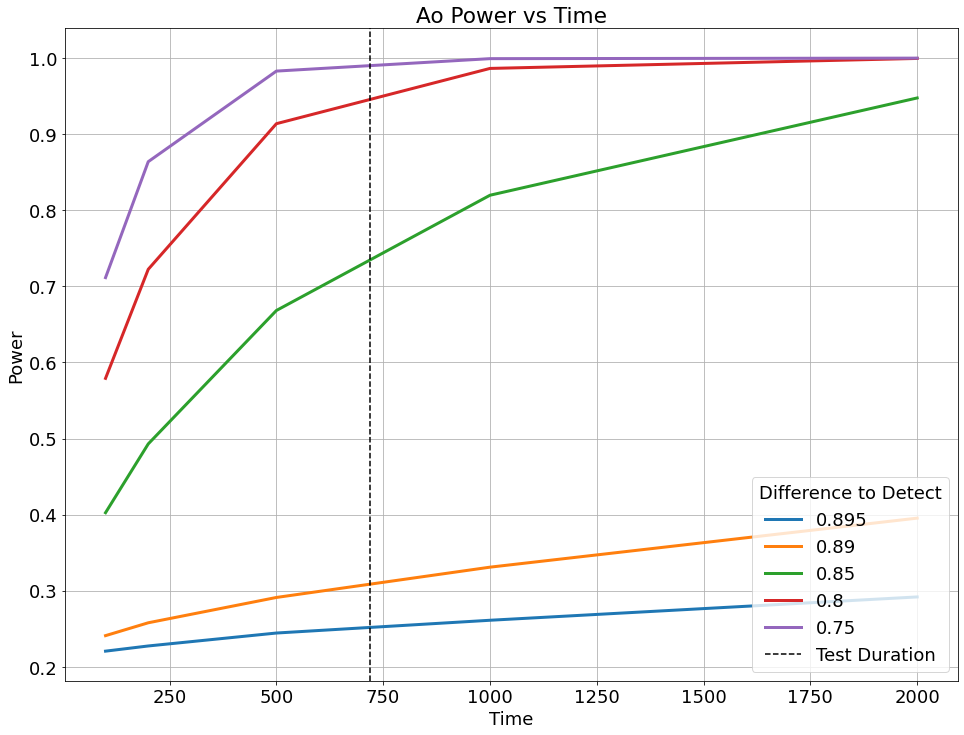

In [53]:
from matplotlib import figure
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import rcParams


plt.rcParams["figure.figsize"] = (16, 12)

SMALL_SIZE = 10
MEDIUM_SIZE = 14
LARGE_SIZE = 18

plt.rc('font', size = LARGE_SIZE)
plt.grid()



for ao, powers in plotter.items():
    plt.plot(TIMES, powers, label=ao, linewidth = 3)
plt.xlabel("Time")
plt.ylabel("Power")
plt.axvline(x= 720, color='k', linestyle='--', label = 'Test Duration')
plt.legend(loc="lower right", title="Difference to Detect")
plt.title("Ao Power vs Time")

plt.show()

The test duration is planned for 720 hours of continuous operations. Given this test duration, a cutoff value of 0.85 will be used for our evaluation. If after 720 hours of testing the point estimate of Ao is less than 0.85, we will conclude that the actual Ao is indeed less than the required Ao of 0.90. If the actual Ao were 0.80 (red line), such an approach has an approximately 94% chance (power) of correctly concluding that the actual Ao is less than 0.90.

### MTBCF

We now want to graph the number of hours testing vs the probability of seeing n failures:

In [58]:
HOURS_OF_TESTING = 720
MAX_TRUE_MTBCF = 1600
MAX_FAILS = 4

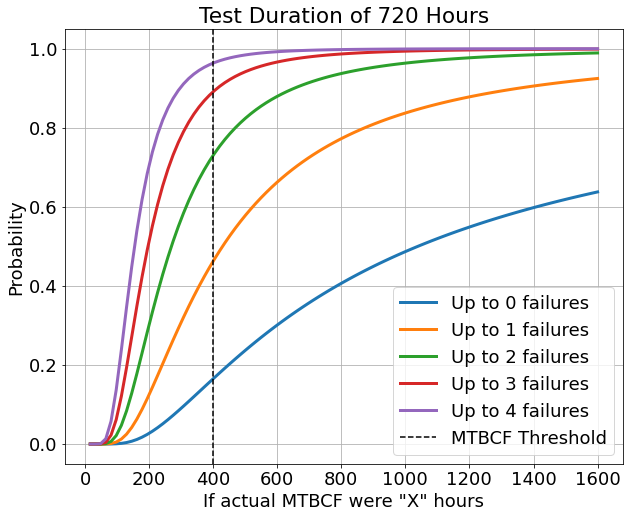

In [59]:
def probabilityOfSeeingUpToXFailures(x, hours_of_testing, true_mtbcf):
  """
  Returns the probability of seeing up to `x` failures given the `true_mtbcf` of the systems and a number of `hours_of_testing`.
  """
  return poisson.cdf(x, hours_of_testing / true_mtbcf)

mtbcfs = np.linspace(MAX_TRUE_MTBCF / 100, MAX_TRUE_MTBCF, 99)
plt.figure(figsize=(10, 8))
for x in range(0, MAX_FAILS + 1):
  ys = probabilityOfSeeingUpToXFailures(x, HOURS_OF_TESTING, mtbcfs)
  plt.plot(mtbcfs, ys, label=f"Up to {x} failures", linewidth = 3)
  
plt.title(f"Test Duration of {HOURS_OF_TESTING} Hours")
plt.xlabel("If actual MTBCF were \"X\" hours")
plt.ylabel("Probability")
plt.axvline(x=400, color='k', linestyle='--', label = 'MTBCF Threshold')
plt.legend()
plt.grid()
plt.show()

In [64]:
probabilityOfSeeingUpToXFailures(3, 720, 400)

0.8912916052907945

In [65]:
probabilityOfSeeingUpToXFailures(4, 720, 400)

0.9635933389989165

In [66]:
probabilityOfSeeingUpToXFailures(4, 720, 400) - probabilityOfSeeingUpToXFailures(3, 720, 400)

0.07230173370812198

If the true MTBCF were 400 hours, and testing lasted 720 hours, there is a .90 probability of seeing up to 3 failures. With only 720 hours of testing, there is not enough time to statistically say with adequate confidence that the actual MTBCF is equal to or greater than 400 hours. What we can do with confidence, however, is set an upper limit on the number of observed failures necessary to confidently state that our system does not meet the threshold. In this case, we can reject a system if the number of failures is 4 or more. Such an approach has a 0.07 probability of rejecting a good system.